## A Correlational Study of Music Engagement and Earliest Musical Memory Vividness 

In this study we investigate the relationships between music engagement of adults and earliest musical memories. In particular, we analyzed if there is any correlation between vividness of these earliest musical memories and music engagement in adult life. 
Our research question can be defined as follows:
What is the relationship between a person’s engagement with music and the vividness of their earliest musical memories? Our hypothesis states that people that are highly engaged with music tend to remember their earliest memories more vividly and with more detail than people who are less musically engaged. 


### The Dataset

To obtain data for our research we conducted a survey with several questions relating to the memory, its vividness as well as demographic information. The results of our analysis of the 59 responses will be presented in this notebook. Before that, we had to preprocess the data from the survey to make it fit for further analysis. The following figure is showing a brief explanation of the filtering process.


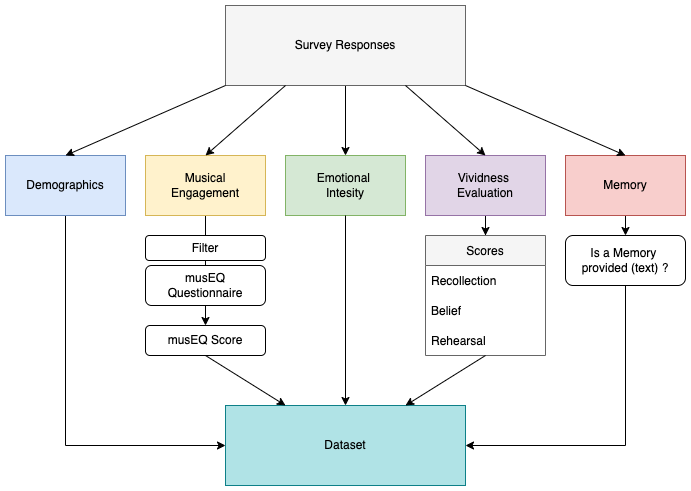

In [1]:
from IPython.display import Image
Image('data/img/mpc_methodology.png')

In [2]:
# Settings
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from PIL import Image
from wordcloud import WordCloud, get_single_color_func
from matplotlib import cm
from matplotlib import colors as cls
from scipy import stats


# Load Dataset
filepath = 'data/MPC Survey Responses Filtered.xlsx'
df = pd.read_excel(filepath)

# Center plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Demographics

In this section we introduce some demographic information of the survey takers. We aimed to reach a diverse population of people with different perspectives towards music to get a balanced representation and explore possible correlations.

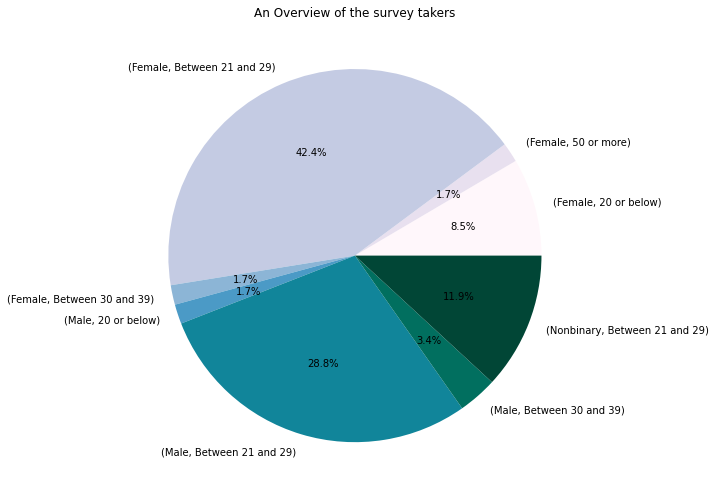

In [3]:
df.groupby(['Gender', 'Age']).size().plot(kind='pie', 
                                          figsize=(10,7), 
                                          ylabel=' ', 
                                          autopct='%1.1f%%', 
                                          title='An Overview of the survey takers',
                                          colormap='PuBuGn')

plt.tight_layout()

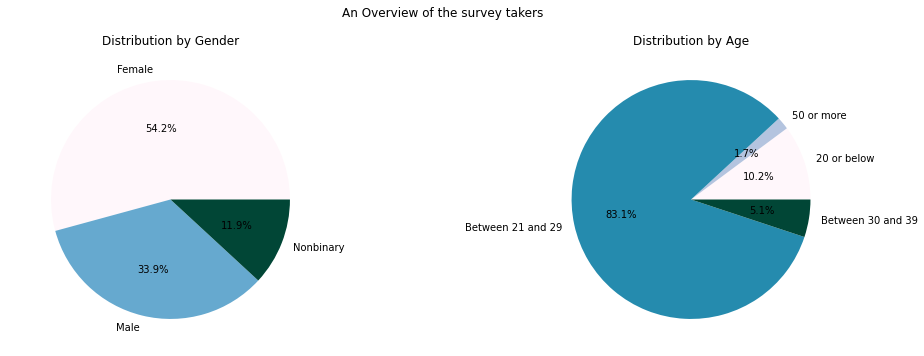

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df.groupby(['Gender']).size().plot(kind='pie', 
                                  figsize=(15,5), 
                                  ylabel=' ', 
                                  autopct='%1.1f%%', 
                                  title='Distribution by Gender',
                                  colormap='PuBuGn',
                                  ax=axes[0])

df.groupby(['Age']).size().plot(kind='pie', 
                                  figsize=(15,5), 
                                  ylabel=' ', 
                                  autopct='%1.1f%%', 
                                  title='Distribution by Age',
                                  colormap='PuBuGn',
                                  ax=axes[1])

fig.suptitle('An Overview of the survey takers')
plt.tight_layout()

### Music Training and Musicality

Here, we introduce visualizations for the music training and the self-reported musicality of the survey takers.

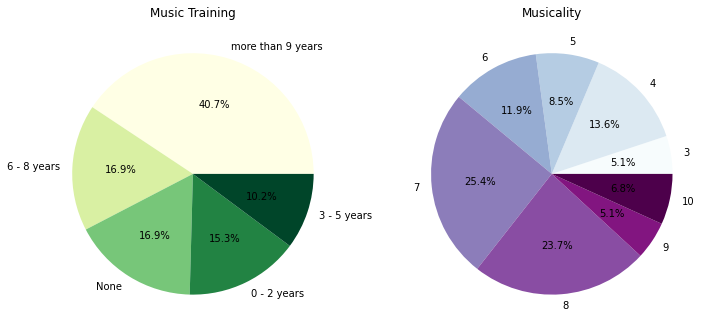

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

df.MusicTraining.value_counts().plot(
                                     kind='pie',
                                     autopct='%1.1f%%',
                                     colormap='YlGn',
                                     ylabel=' ',
                                     ax=ax[0],
                                     title='Music Training')

df.MusicalityRating.value_counts().sort_index().plot(
                                     kind='pie',
                                     ylabel=' ',
                                     colormap='BuPu',
                                     ax=ax[1],
                                     autopct='%1.1f%%',
                                     title='Musicality')

plt.tight_layout()

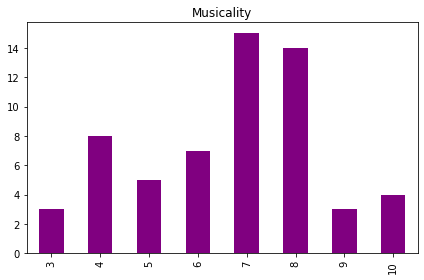

In [6]:
df.MusicalityRating.value_counts().sort_index().plot(kind='bar',
                                                   color='purple',
                                                   title='Musicality')
plt.tight_layout()

We can see that almost half of the participants have more than 9 years of musical training which need to be taken in consideration when making conclusions. Also we can see that around half of the survey takers would rate their musicality high (>= 7).

### Music Engagement

We now present the scores outcome of the musEQ questionnaire. The musEQ paper can be found [here](DOI:10.1080/13607863.2015.1021750). The original questionnaire contains 35 items for 6 categories which we shrinked down to 8 items for 6 categories to make it fit for the scope of our work. We then used the mean and median value for each category and obtained the global musEQ score which is presented in the following figures.

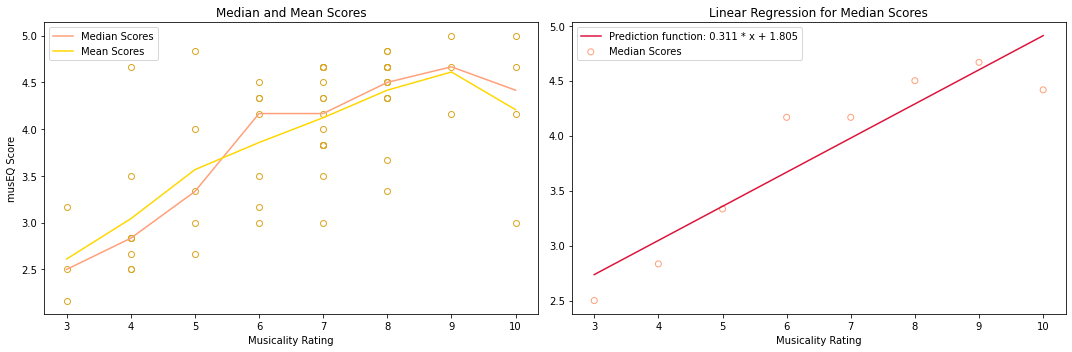

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(df.MusicalityRating, df.musEQScore, 'o', fillstyle='none', color='goldenrod')
df.groupby('MusicalityRating')['musEQScore'].median().plot(xlabel='Musicality Rating',
                                                         ylabel='musEQ Score',
                                                         label='Median Scores',
                                                         color='lightsalmon',
                                                         ax=ax[0]).legend(loc='upper left')

df.groupby('MusicalityRating')['musEQScore'].mean().plot(xlabel='Musicality Rating',
                                                         ylabel='musEQ Score',
                                                         label='Mean Scores',
                                                         color='gold',
                                                         title='Median and Mean Scores',
                                                         ax=ax[0]).legend(loc='upper left')

# Fitting a linear function to show relationship
X = np.transpose(np.array([3,4,5,6,7,8,9,10]).reshape(1,-1))
y = np.array(df.groupby('MusicalityRating')['musEQScore'].median())
lr = LinearRegression().fit(X,y)

ax[1].scatter(X, y, marker='o', facecolors='none', color='lightsalmon', label='Median Scores')
ax[1].plot(X, 
           lr.predict(X) , 
           color='crimson', 
           label='Prediction function: {coef:.3f} * x + {intercept:.3f}'
           .format(coef=lr.coef_[0], intercept=lr.intercept_))
ax[1].set_xlabel('Musicality Rating')
ax[1].legend()
ax[1].set_title('Linear Regression for Median Scores')

plt.tight_layout()

In [8]:
r_musEQ_Musicality = stats.pearsonr(df['MusicalityRating'], df['musEQScore'])
print("Pearson correlation between self-reported musicality rating and musEQ results: \n")
print("(r, p-value) --> ", r_musEQ_Musicality)

Pearson correlation between self-reported musicality rating and musEQ results: 

(r, p-value) -->  (0.6520439206708077, 2.215274927511864e-08)


We can see in the above graphs the increasing tendency of the relationship, and this has been confirmed when computing the Pearson correlation coefficient and the associated p-value. The Pearson correlation coefficient is 0.65 and the p-value is very low (2.2e-08), therefore, since p<<0.05, we can reject the null hypothesis (Null hypothesis: no relationship between musicality and musEQ scores), and confirm that these two variables are positive correlated as expected. In other words, people that consider themselves as musical persons, have a higher score in the musical engagement questionnaire. We will use the music engagement score as measured with the MusEQ questionnaire for the rest of the analysis. Now we will investigate if there are any correlations between the vividness and the musical engagement.

### Vividness of the Earliest Musical Memories

In this section we present our results on the relationship between vividness and music engagement as measured by the musEQ questionnaire. To measure the vividness of the memory, we presented the participants with 9 questions in 3 categories which are standard constructs of the vividness of autobiographical memories, as well as 1 additional question in which subjects scored from 1 to 5 the overall vividness: 
1. Recollection (level of sensory details of the earliest musical memory)
2. Belief (confidence about the memory)
3. Rehearsal (how usually the person thought about the memory after it happened, either voluntary or involuntary)
4. Self-reported vividness ("The memory appears vivid and clear", score from 1 (not at all) to 5 (to a very high degree))

The questions to measure the first 3 categories were taken from [here](https://doi.org/10.1080/09658211.2017.1414849), scored from 1 to 7. The original set of questions contained 14 items within 4 categories and we shrinked it down to 9 memories in 3 categories which contain the 2 main categories for vividness (recollection and belief) and one of the auxiliary categories (rehearsal). 

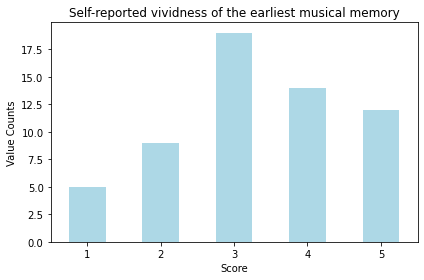

In [9]:
df.MQ2.value_counts().sort_index().plot(kind='bar', 
                                        color='lightblue', 
                                        title='Self-reported vividness of the earliest musical memory',
                                        ylabel='Value Counts', 
                                        rot=0, 
                                        xlabel='Score')
plt.tight_layout()

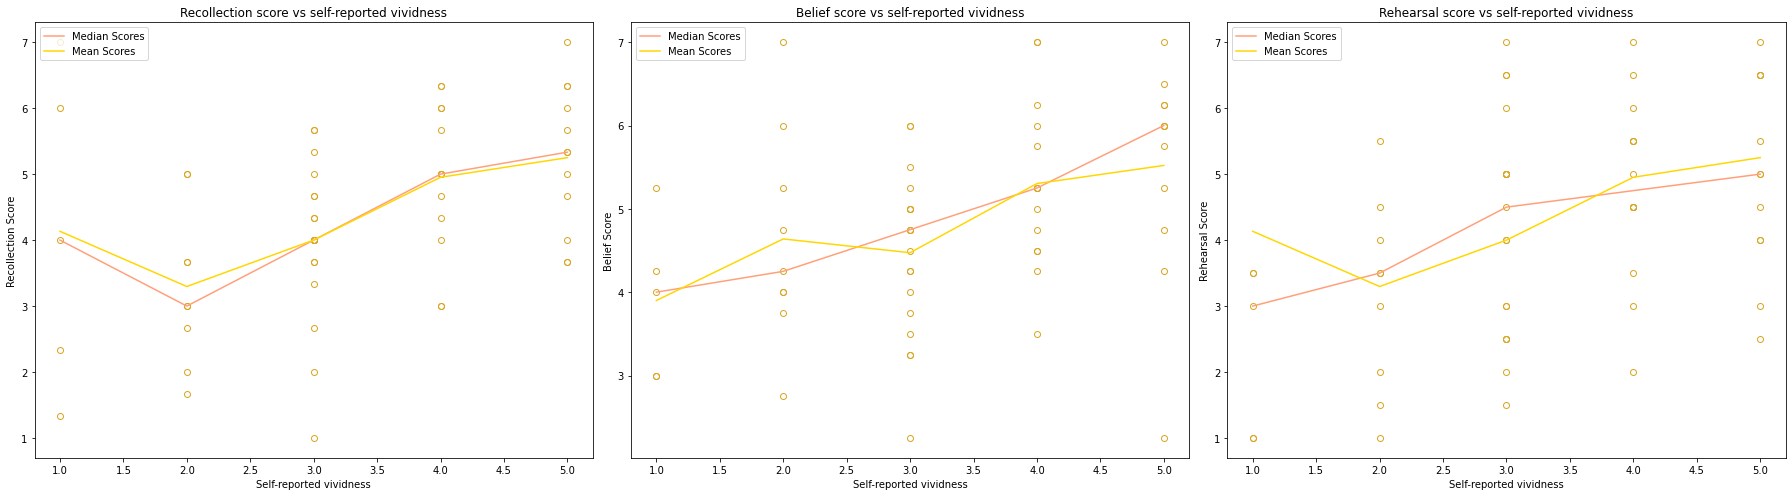

In [10]:
fig, ax = plt.subplots(1,3,figsize=(25,7))

ax[0].plot(df['MQ2'], df['RecollectionScore'], 'o', fillstyle='none', color='goldenrod')
df.groupby('MQ2')['RecollectionScore'].median().plot(xlabel='Self-reported vividness',
                                                     ylabel='Recollection Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                     ax=ax[0]).legend(loc='upper left')

df.groupby('MQ2')['RecollectionScore'].mean().plot(xlabel='Self-reported vividness',
                                                   ylabel='Recollection Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Recollection score vs self-reported vividness',
                                                   ax=ax[0]).legend(loc='upper left')

ax[1].plot(df['MQ2'], df['BeliefScore'], 'o', fillstyle='none', color='goldenrod')
df.groupby('MQ2')['BeliefScore'].median().plot(xlabel='Self-reported vividness',
                                                     ylabel='Belief Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                     ax=ax[1]).legend(loc='upper left')

df.groupby('MQ2')['BeliefScore'].mean().plot(xlabel='Self-reported vividness',
                                                   ylabel='Belief Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Belief score vs self-reported vividness',
                                                   ax=ax[1]).legend(loc='upper left')

ax[2].plot(df['MQ2'], df['RehearsalScore'], 'o', fillstyle='none', color='goldenrod')
df.groupby('MQ2')['RehearsalScore'].median().plot(xlabel='Self-reported vividness',
                                                     ylabel='Rehearsal Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                     ax=ax[2]).legend(loc='upper left')

df.groupby('MQ2')['RecollectionScore'].mean().plot(xlabel='Self-reported vividness',
                                                   ylabel='Rehearsal Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Rehearsal score vs self-reported vividness',
                                                   ax=ax[2]).legend(loc='upper left')

plt.tight_layout()

As we can see in the previous plots, the mean and median linegraphs show an increasing tendency for the 3 vividness categories when compared with the self-reported vividness. In other words, in average, subjects that score themselves to have high vividness of their earliest musical memory also score higher in recollection, belief and rehearsal categories, and viceversa (the lower the self-reported vividness, the lower they score in the 3 categories). For the rest of the analysis, we will use these 3 categories as representations of the vividness of the memories. 

### Vividness and music engagement

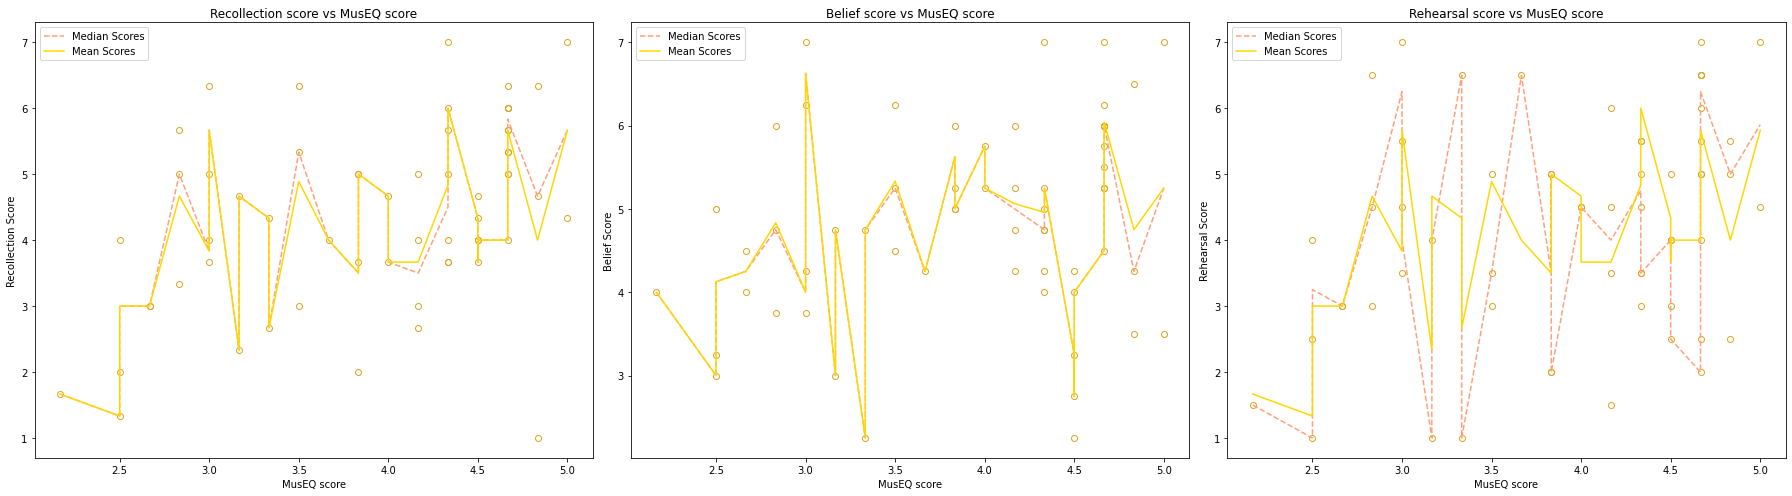

In [11]:
fig, ax = plt.subplots(1,3,figsize=(25,7))

ax[0].plot(df['musEQScore'], df['RecollectionScore'], 'o', fillstyle='none', color='goldenrod')
df.groupby('musEQScore')['RecollectionScore'].median().plot(xlabel='MusEQ score',
                                                     ylabel='Recollection Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                     style='--',
                                                     ax=ax[0]).legend(loc='upper left')

df.groupby('musEQScore')['RecollectionScore'].mean().plot(xlabel='MusEQ score',
                                                   ylabel='Recollection Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Recollection score vs MusEQ score',
                                                   ax=ax[0]).legend(loc='upper left')

ax[1].plot(df['musEQScore'], df['BeliefScore'], 'o', fillstyle='none', color='goldenrod')
df.groupby('musEQScore')['BeliefScore'].median().plot(xlabel='MusEQ score',
                                                     ylabel='Belief Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                      style='--',
                                                     ax=ax[1]).legend(loc='upper left')

df.groupby('musEQScore')['BeliefScore'].mean().plot(xlabel='MusEQ score',
                                                   ylabel='Belief Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Belief score vs MusEQ score',
                                                   ax=ax[1]).legend(loc='upper left')

ax[2].plot(df['musEQScore'], df['RehearsalScore'], 'o', fillstyle='none', color='goldenrod')
df.groupby('musEQScore')['RehearsalScore'].median().plot(xlabel='MusEQ score',
                                                     ylabel='Rehearsal Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                         style='--',
                                                     ax=ax[2]).legend(loc='upper left')

df.groupby('musEQScore')['RecollectionScore'].mean().plot(xlabel='MusEQ score',
                                                   ylabel='Rehearsal Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Rehearsal score vs MusEQ score',
                                                   ax=ax[2]).legend(loc='upper left')
plt.tight_layout()

We can see from the previous plots that the mean and median values for the 3 categories show a more complicated pattern when displayed with respect to the MusEQ score, however, an increasing trend can be slighly perceived. In order to have an in-depth view of these relationships, we will perform a correlational study in the next section where we will aim at rejecting the null hypotheses to show that there is actually a natural relationship between the 3 vividness constructs (recollection, belief and rehearsal) and the music engagement as measured by the MusEQ questionnaire.

### Correlational Analysis: Vividness vs Music Engagement

We look for possible correlations between *Vividness* and the *Music engagement* using the measured scores. After each score is calculated we experimented with various correlation measures such as Pearson and Spearman correlation coefficients. Since the Pearson coefficient has the underlying assumption of a linear relationship with constant rate of increase/decrease between the variables, we chose the Spearman coefficient for the final analysis to account for possible monotonic relationships.

From the following plots we see that:
- scores are pairwise **positively** correlated with varying levels of non-linear correlation
- correlations could be classified as **mild**, (between 0.2 and 0.5)
- maximum correlation with **MusEQ** occurs for the **Recollection** score with a *0.45* correlation coefficient.
- minimum correlation with **MusEQ** occurs with **Belief** score with *0.27* correlation coefficient.

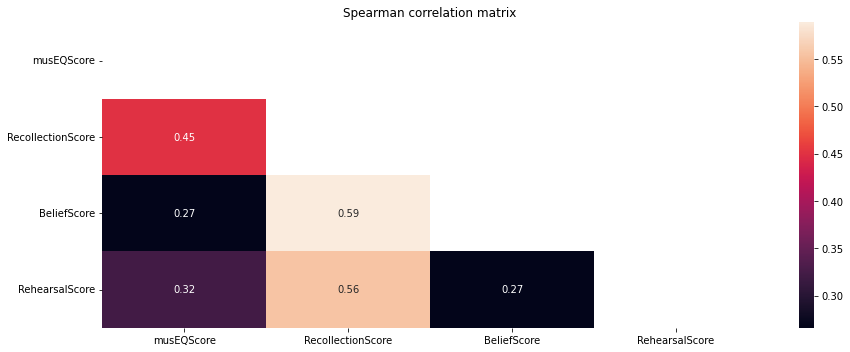

In [13]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
corr = df[['musEQScore', 'RecollectionScore', 'BeliefScore', 'RehearsalScore']].corr(method='spearman')
mask = np.zeros_like(corr)
tria = np.triu_indices_from(mask)
mask[tria] = True

sns.heatmap(corr, mask=mask, annot=True)

plt.title('Spearman correlation matrix')
plt.tight_layout()

In [14]:
s_musEQ_Recollection = stats.spearmanr(df['musEQScore'], df['RecollectionScore'])
s_musEQ_Belief = stats.spearmanr(df['musEQScore'], df['BeliefScore'])
s_musEQ_Rehearsal = stats.spearmanr(df['musEQScore'], df['RehearsalScore'])

print("Spearman correlation between MusEQ score and Recollection score: \n")
print(s_musEQ_Recollection, "\n\n")

print("Spearman correlation between MusEQ score and Belief score: \n")
print(s_musEQ_Belief, "\n\n")

print("Spearman correlation between MusEQ score and Rehearsal score: \n")
print(s_musEQ_Rehearsal)

Spearman correlation between MusEQ score and Recollection score: 

SpearmanrResult(correlation=0.4489756141485935, pvalue=0.00036140752585448214) 


Spearman correlation between MusEQ score and Belief score: 

SpearmanrResult(correlation=0.2658662795194698, pvalue=0.04182544913708997) 


Spearman correlation between MusEQ score and Rehearsal score: 

SpearmanrResult(correlation=0.3215315617610693, pvalue=0.01302025851125982)


We can confirm from the above results that each of the 3 vividness scores (recollection, belief and rehearsal) has a natural relationship with the music engagement, as indicated by the p-value being less than 0.05 (< 5%) for the 3 cases. The relationship with the music engagement is stronger for the case of the recollection score, which measures the amount of sensory details of the earliest musical memory, giving the lowest p-value for the 3 cases. The relationship with the music engagement is less strong for the belief score, with a p-value of 4.1%, although still low enough to reject the null hypothesis (which states that there is no natural relationship between the two variables). 

### Additional analyses about the earliest musical memories

In addition to the vividness questions, the following ones were asked in the survey about earliest musical memories of the participants. The subjects had to rate their answers from 1 to 5. 

1. Think about the first musical or sonic experience you remember in your childhood. Try to hear it for yourself if you can. Think about the earliest situation or experience that comes to your mind that involved that song or melody.  How old were you when the episode took place?

2. To what extent does the following statement match your earlierst memory of a song or melody? -> The episode was typical for my everyday life at that time.

3. When you recall your experience, does it then appear as a coherent episode with a beginning and an end, or is it more like one or more fragments?

4. When you recall the episode, are the emotions you experience then positive or negative?


We can categorize these four questions into:
1. Age 
2. Typicality 
3. Fragmentation 
4. Emotion valence

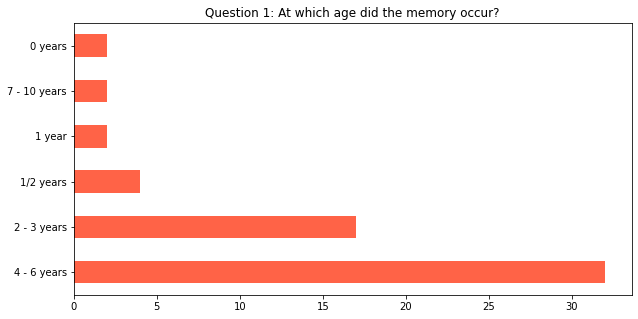

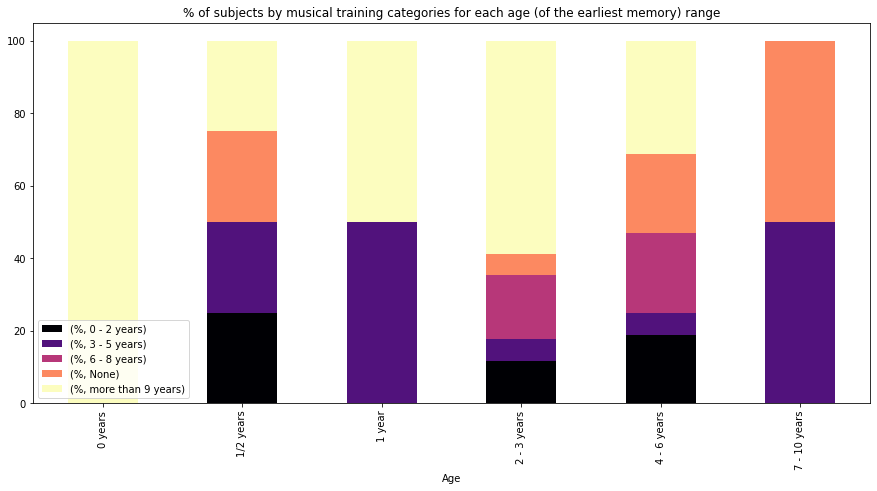

<Figure size 432x288 with 0 Axes>

In [34]:
fig, ax = plt.subplots(figsize=(10,5))

df.MQ1.value_counts().plot(kind='barh',
                           color='tomato',
                           title='Question 1: At which age did the memory occur?')

grouped_dataset = df.groupby(['MQ1', 'MusicTraining'])["MQ2"].count() * 100.0 / df.groupby(["MQ1"])["MQ2"].count()
grouped_dataset.reset_index()
df2 = pd.DataFrame(grouped_dataset)
df3 = pd.pivot_table(df2, index=['MQ1'], columns=['MusicTraining'], aggfunc=np.sum, fill_value=0)
df3 = df3.reindex(["0 years", "1/2 years", "1 year", "2 - 3 years", "4 - 6 years", "7 - 10 years"])
df3.rename(columns={"MQ2" : "%"}, inplace=True)
df3.index.names = ['Age']

fig = plt.figure(figsize=(15, 7))
df3.plot.bar(stacked=True, ax=fig.gca(), colormap='magma')
plt.legend(loc='lower left')
plt.title("% of subjects by musical training categories for each age (of the earliest memory) range")
plt.show()

plt.tight_layout()

From this figures we can see that most subjects place their earliest musical memory at the age range of 4 to 6 years. The second most common age range was 2 to 3 years old, so we can see that most earliest musical memories were located on the age range from 2 to 6 years old. Looking at the second bar graph above, we can see that for these 2 age ranges, there are not significant differences in regard to the musical training. In other words, independently of the musical training they had, subjects were more likely to place their earliest musical memories on the age range of 2 to 6 years old. It should be noticed that the purple category (people with more than 9 years of musical training) is more common, but this could be due to the fact that almost half of the subjects had more than 9 years of musical training, so this is a bias that further studies should avoid. 

Now, we plot the value counts for the other additional variables addressed by the survey, namely: typicality (the episode was typical for my everyday life at that time, 1 (no typical at all) to 5 (very typical), fragmentation (memory as coherent episode with a beginning and end, 1 (no coherent at all) to 5 (very coherent)) and emotional valence (emotions as positive or negative, 1 (very negative) to 5 (very positive)).

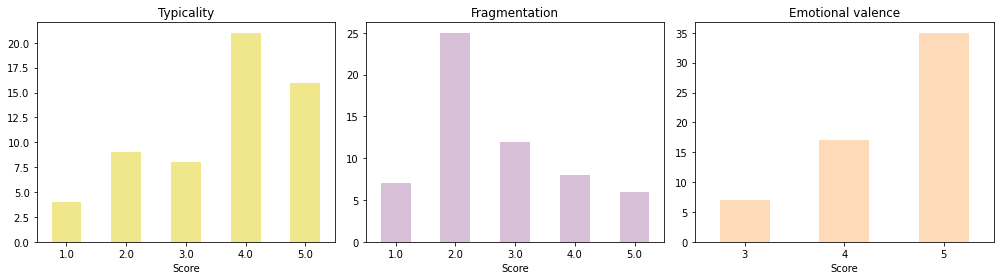

In [16]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

x = np.arange(len(df.MQ2.value_counts().sort_index()))
df.MQ3.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[0],
                                        title='Typicality',
                                        color='khaki', 
                                        rot=0, 
                                        xlabel='Score')
df.MQ4.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[1],
                                        title='Fragmentation',
                                        color='thistle', 
                                        rot=0, 
                                        xlabel='Score')
df.MQ5.value_counts().sort_index().plot(kind='bar', 
                                        ax=ax[2],
                                        title='Emotional valence',
                                        color='peachpuff', 
                                        rot=0, 
                                        xlabel='Score')

plt.tight_layout()

From these charts we can clearly see that: (1) subjects tend to score the typicality of their earliest musical memories as high, meaning that in average their earliest musical memories were typical episodes in their childhood, (2) subjects tend to score the fragmentation of their earliest musical memories as slightly low to neutral, meaning that these earliest memories were reminded as episodes with no such a clear beginning and end but more as a collection of fragments, (3) subjects tend to score the emotional valence of their earliest musical memories as positive to very positive, meaning that these episodes brought in average positive emotions. 

Finally, for these additional variables, we focus on the "typicality" and try to extract a relationship with the "rehearsal" value from the vividness questions. Our research hypothesis here is: the more typical the episodes of the earliest musical memories are the more usually the subjects thought about them, voluntary or involuntary. In order to confirm this hypothesis, we first do a simple plot of the two variables with their mean and median, and then compute (as in the previous analyses) the Spearman correlation factor and its p-value.

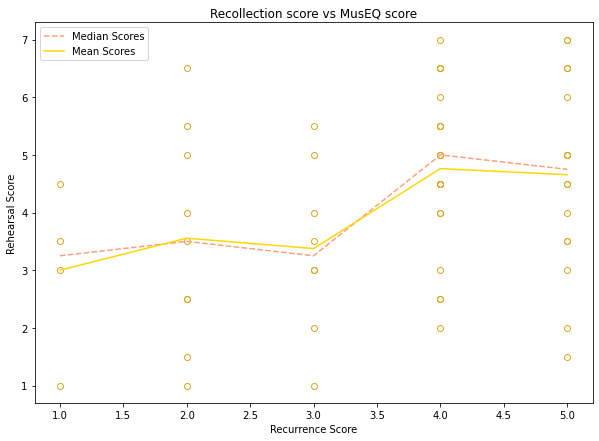

In [17]:
data = [df["MQ3"], df["RehearsalScore"]]
df4 = pd.concat(data, axis=1).dropna()

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df4['MQ3'], df4['RehearsalScore'], 'o', fillstyle='none', color='goldenrod')
df4.groupby('MQ3')['RehearsalScore'].median().plot(xlabel='Recurrence Score',
                                                     ylabel='Rehearsal Score',
                                                     label='Median Scores',
                                                     color='lightsalmon',
                                                     style='--').legend(loc='upper left')

df4.groupby('MQ3')['RehearsalScore'].mean().plot(xlabel='Recurrence Score',
                                                   ylabel='Rehearsal Score',
                                                   label='Mean Scores',
                                                   color='gold',
                                                   title='Recollection score vs MusEQ score').legend(loc='upper left')

In [18]:
s_Recurrence_Rehearsal = stats.spearmanr(df4['MQ3'], df4['RehearsalScore'])

print("Spearman correlation between Recurrence score and Recollection score: \n")
print(s_Recurrence_Rehearsal)

Spearman correlation between Recurrence score and Recollection score: 

SpearmanrResult(correlation=0.31942714269943084, pvalue=0.01452006715890203)


As we can see, although the correlation value is mild (0.31), the p-value being 1.45% indicates that it is enough to reject the null hypothesis, and therefore, show that there is a natural positive correlation between both variables, so the previous research hypothesis can be confirmed.

### Memories

In this section we are going to have a look at the memories provided by the participants as well as investigating if people with high musical engagement tend to take the time to write down the memory they were thinking of. We will first have a look at how many people provided a memory and then taking a closer look at the details.

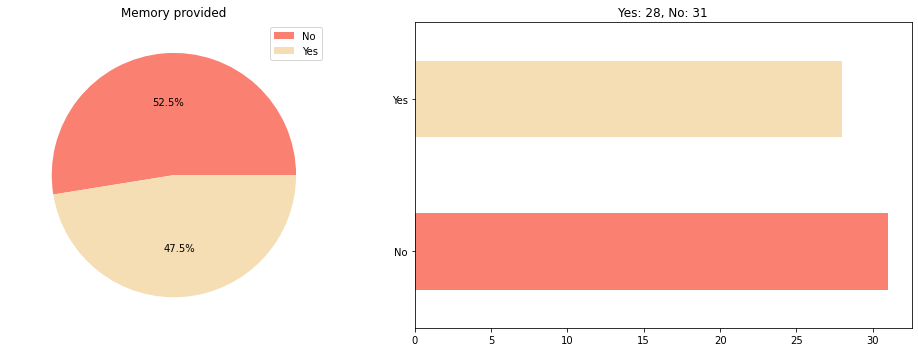

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

colors=['salmon', 'wheat']

df.MemoryProvided.value_counts().plot(kind='pie',
                                      title='Memory provided',
                                      labels=None,
                                      ax=ax[0],
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      ylabel=' ').legend(loc='upper right', labels=['No', 'Yes'])

df.MemoryProvided.value_counts().set_axis(['No', 'Yes']).plot(
                                      kind='barh',
                                      ax=ax[1],
                                      color=colors,
                                      title='Yes: {yes}, No: {no}'.format(yes=df.MemoryProvided.value_counts()[1],
                                                                          no=df.MemoryProvided.value_counts()[0]))

plt.tight_layout()

In the previous figure we can see, that slightly less than half of the participants answered the optional part of providing the memory they were thinking of. Sadly, this is a bad position to make assumption from, but we still want to have a look on the relationship of the musical engagement score and the is_provided key.

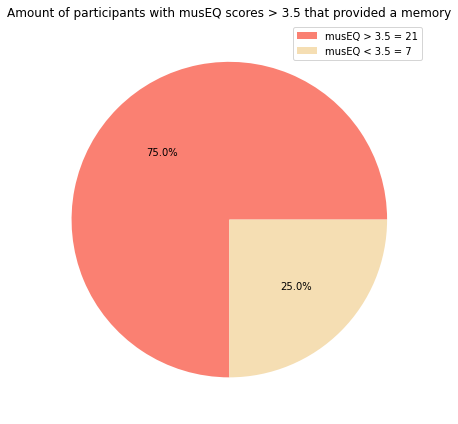

In [20]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

# Calculate amount of musEQ Scores > 3.5 from the amount of people that provided memories
musEq = np.array(df.musEQScore)
is_provided = np.transpose([musEq[idx] for idx in [np.where(df.MemoryProvided == 1)]]).reshape(28,)
is_high = is_provided[is_provided > 3.5]
yes = np.ones(len(is_high))
no  = np.zeros(df.MemoryProvided.value_counts()[1] - len(is_high))

pie = pd.DataFrame(np.concatenate([yes,no]))

colors=['salmon', 'wheat']
pie.value_counts().plot(kind='pie',
                        title='Amount of participants with musEQ scores > 3.5 that provided a memory',
                        autopct='%1.1f%%',
                        labels=None,
                        ylabel=' ',
                        colors=colors
                      ).legend(loc='upper right',labels=['musEQ > 3.5 = {amount}'.format(amount=len(is_high)),
                                                        'musEQ < 3.5 = {amount}'.format(
                                                        amount=df.MemoryProvided.value_counts()[1] - len(is_high)),])

plt.tight_layout()

In the previous plot we can obtain, that from 28 people who provided a memory 75 percent (21 participants) have high musical engagement. 

#### Memories and Keywords

Finally, we are going to present the open question results. We used kmeans to provide some basic text clustering and plotted the first 5 feature names for each cluster in a wordcloud below. 
The long text answers can be found in the survey excel.

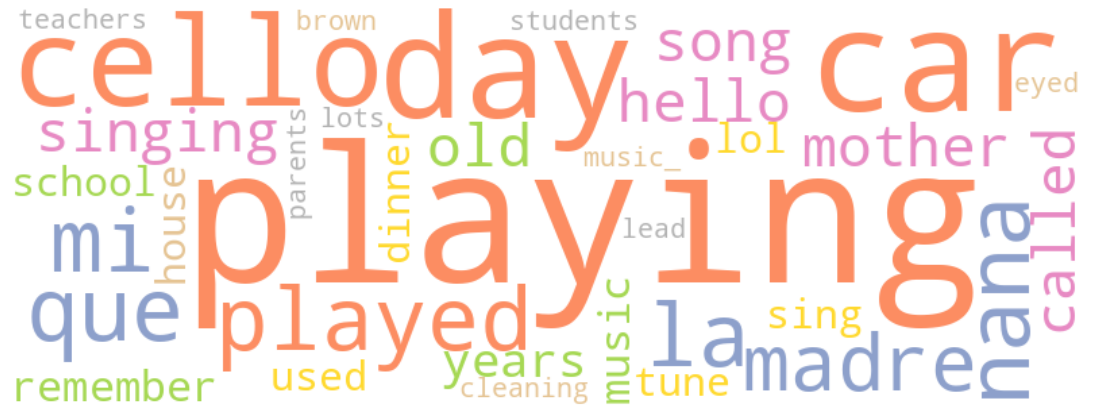

In [21]:
plt.figure(figsize=(15,6))

textfiles = df.Memories.astype('U')
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(textfiles)

k = 8
kmeans = KMeans(n_clusters=k, max_iter=100, init='k-means++', n_init=1, random_state=10)
kmeans.fit(features)

df['clusters'] = kmeans.labels_

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

cmap = cm.get_cmap('Set2', 8)    # PiYG

clrs = []
for i in range(cmap.N):
    rgba = cmap(i)
    clrs.append(cls.rgb2hex(rgba))

### Code from wordcloud doc -----
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word)
### ----

color_to_words = {}
keywords = []
for i in range(k):
    temp = []
    if(i == 0):
        continue
    for j in order_centroids[i,:5]:
        if not (terms[j] in keywords):
            temp.append(terms[j])
            keywords.append(terms[j])
        else:
            temp.append(terms[j] + '_')
            keywords.append(terms[j] + '_')
    color_to_words.update({clrs[i] : temp})
    
keywords = np.array(keywords)

strings = (" ").join(keywords)
wc = WordCloud(collocations=True, width=800, height=300, background_color='white').generate(strings)
color_func = SimpleGroupedColorFunc(color_to_words)
wc.recolor(color_func=color_func)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')

plt.tight_layout(pad=0)

Here we are plotting the first 5 feature names of the eight clusters of the text answers. As we can see, the categories contain mostly keywords associated with positive memories of childhood, family and musical instruments which emphasize our findings from above on mostly positive ratings for the memories. In the following section we provided some of the memories to just have a basic overview of what the participants answered (with the respective color to compare with the keywords).

In [22]:
from IPython.display import display, Markdown

s = ''
for idx, sent in enumerate(df.Memories):
    if str(sent) == 'nan':
        continue
    c = clrs[kmeans.labels_[idx]]
    display(Markdown("<font color='" + c + "'>'" + sent + "</font>"))

<font color='#a6d854'>'I was five years old, and I remember very clearly staying at my big sister's bedroom, in a very specific corner of the room. I was trying to memorize the lyrics of a song which I really liked as a child. The song was "Dime", the first single of an ex-participant of a famous Spanish TV music reality show ("Operación Triunfo"), called Beth. I was clearly excited about this singer, possibly because we share a similar name. As I remember, I was at this particular place in my sister's bedroom next to a music stereo system and in front of a window, and I was playing that song and stopping at every end of line in order to write it down in a piece of paper. I also remember one of my sisters, I think the oldest, standing next to me and correcting and guiding me while I was writing the lyrics. I repeated each line several times to memorize it, I was very happy and clearly excited to do this exercise, humming the song as I listened and wrote the lyrics.</font>

<font color='#a6d854'>'My great uncle came for a visit. He sat at the piano and played jazz or ragtime music. It was fun and completely different and I remember being amazed at how easily his fingers flew across the keys to make beautiful sounds. I must have been about 3 years old</font>

<font color='#a6d854'>'My first concert - James Taylor at an outdoor venue at nighttime in the summer. I was maybe 2 years old and was sitting on my dad’s shoulders. I remember his face being shadowed on stage, and the moon was big and bright. The song was “Carolina in my Mind”. </font>

<font color='#e78ac3'>'Singing a very specific hello song with my mother </font>

<font color='#ffd92f'>'I remember my father used to sing a tune which he made up his own when serving the dinner or lunch. The whole family was happy and we laugh at that tune. </font>

<font color='#fc8d62'>'My mother is a cellist and every single day she practices and plays bach cello suite to warm up. I have such a distinct memory of the tune but she played it so often that the event of me hearing it as a child is very jumbled because she played it around me every day for the first few years of my life. </font>

<font color='#e5c494'>'My Blues Clues Solar System toy that sang about all the planets! I would play with it all the time. Well the sun's a hot staaarrrr 🎶</font>

<font color='#ffd92f'>'My dad used to always blast music while he was cooking dinner. I remember him listening to mobey a lol lol. </font>

<font color='#b3b3b3'>'We held a short dance performance in kindergarten for our parents. There were lots of parents, teachers, and students. All of us students had matching outfits and one of the teachers helped lead the choreography. </font>

<font color='#ffd92f'>'My mom used to sing me a Hebrew song to help me go to sleep when I was little and would tuck my hair behind my ear </font>

<font color='#a6d854'>'Hey Sam, it’s me Arturo Manzo. Cool work with this survey, hope you get a collective amount. The memory I was thinking about was Christmas music on Christmas Day, most emotional experience to remembering; with all the anxiety in the world to see if I was getting gifts from “Santa. But because my parents never stopped listening to the same song over and over, ‘Feliz Navidad’ haha. Cheers buddy :D</font>

<font color='#e5c494'>'I always remember my parents cleaning the house to brown eyed girl </font>

<font color='#fc8d62'>'My first musical memory is practicing the cello with my mom. I had just started playing and my parents were still looking for a cello for my size, so the first couple months of playing were on a wooden facsimile my dad made. The strings were drawn on so I had to sing everything I “played”. This particular memory is of my mother directing me through my practicing and me singing her a song I made up while playing. She would always let me do this at the end of each practice session together growing up.</font>

<font color='#e5c494'>'I loved ballet as a kid and would have my mom turn on music for me to dance to in our living room. I remember such occasion wearing a yellow dress and dancing to the same classic piece over and over </font>

<font color='#e78ac3'>'my mother in her rocking chair, singing to me as i’m about to fall asleep in a dark room with light coming in from the hallway, “all my loving” by the beatles </font>

<font color='#e5c494'>'My mom was really into the clubbing scene in New York during the late 80s and 90s and was really into like house music which she played all the time around the house when we were cleaning. House music is cool asf </font>

<font color='#8da0cb'>'A Christmas roadtrip to Granada with my parents when I was around 3. My father was driving while my mother was searching for the right road on a map. We were listening to La Oreja de Van Gogh’s CD “Lo que te conté mientras te hacías la dormida”. </font>

<font color='#8da0cb'>'Se trata de una nana que mi madre solía cantarme, la tenía medio en el inconsciente hasta que nació mi sobrina y se la cantó. Tan pronto como empezó me vino toda la letra y melodía a la cabeza y eso que llevaba 20 años sin escucharla.</font>

<font color='#fc8d62'>'I remember watching my sister playing the piano. That day she started showing me how to play a little bit for the first time.</font>

<font color='#e78ac3'>'My grandma singing me a song called “Chalaneru” in order to make me sleepy </font>

<font color='#8da0cb'>'La nana que me cantaba mi madre para dormir </font>

<font color='#a6d854'>'There was a Disney songs  casette in my home. I remember playing "Colors in the wind", from Pocahontas on repeat, when i was little.</font>

<font color='#e78ac3'>'Its a memory of my dad singing to me a french song called Alouette, although he doesnt speak any french I loved the weird but calming sounds he produced while singing, I remember laughing and trying to imitate de words. Even now I have no idea what the song is about. </font>

<font color='#fc8d62'>'I remember every time I was on my father's car, the first song playing on the CD player was You never can tell by Chuck Berry, and as soon as I entered the car I would start dancing to that song.</font>

<font color='#ffd92f'>'Lullaby songs: two that my father created por me and my sister and onw that my mother used to sing in the morning as she opened our window. She still sings that song whenever se calls us in the morning.</font>

<font color='#a6d854'>'I remember listening to Tears In Heaven during an English class at school when I was about 9 years old. With the teacher we were listening to the song and trying to understand what it meant, translating it to Spanish. I also remember singing it at home after that lesson and thinking I wanted to be a singer when I grew up</font>

<font color='#8da0cb'>'i was in kindergarden and a music teacher introduced the concept of "do re mi fa sol la si" to me.</font>

<font color='#a6d854'>'My early music school graduation (8 years old)</font>

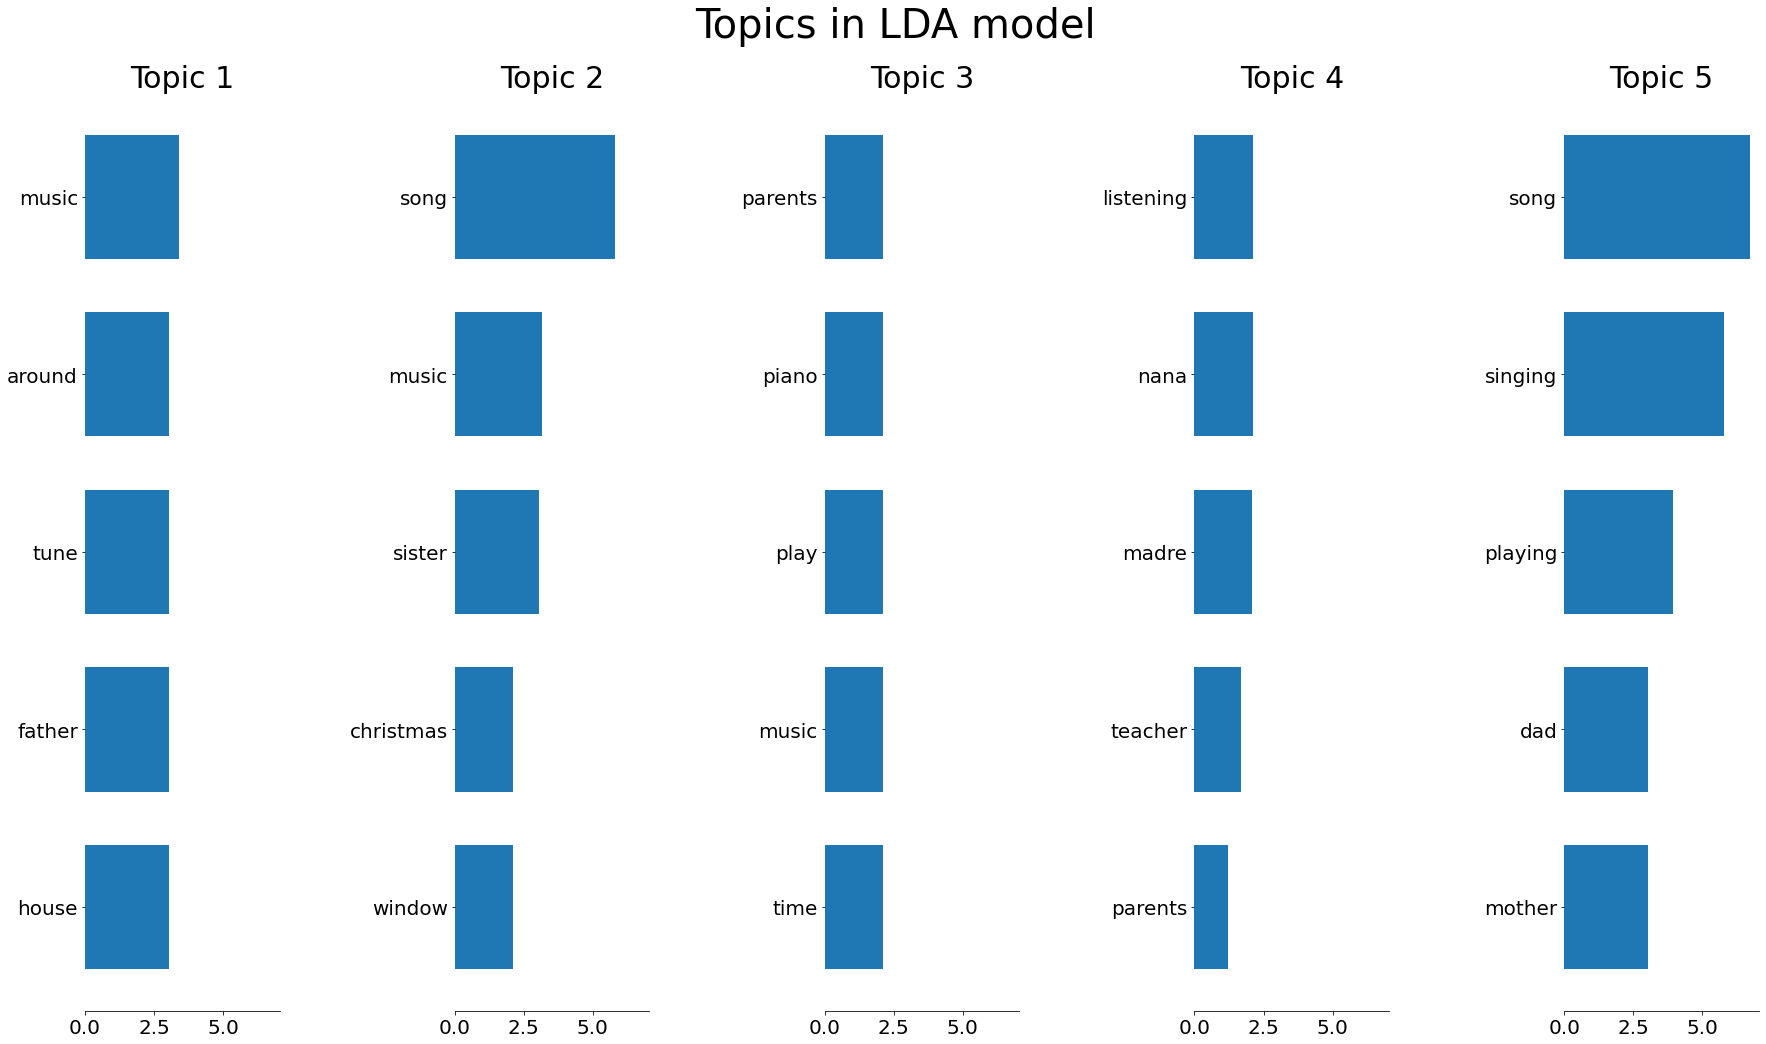

In [23]:
nltk.download('stopwords', quiet=True)

stopword_en = nltk.corpus.stopwords.words('english')
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword = stopword_en + stopword_es + ['remember','made','first','would','used','years','old','every','order']

mems = df.Memories.dropna()

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=1000, stop_words=stopword 
)

tf = tf_vectorizer.fit_transform(mems)

lda = LatentDirichletAllocation(
    n_components=5,
    max_iter=50,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)

lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, 5, "Topics in LDA model")



These generated topics give us a rough sense of the most common contexts and ways of describing the memories provided in the survey. More work could be done to properly stem the words so that "play" is considered equivalent to "playing", for example. This is difficult because the text responses included both english and spanish, which gramatically have different methods of stemming words.

Either way, these five topics show us that these memories are strongly associated with home, parents or other elders, and holidays.


### Conclusions

- There is a natural positive correlation between vividness and music engagement in terms of the recollection (sensory details), belief (confidence) and rehearsal (how usually the person thought about the memories), being stronger for the recollection, then for the rehearsal and less stronger for the belief aspect.
- Self-reported metrics for musicality and vividness were positively correlated with their correspondent scores using state-of-the-art approaches (musEQ questionnaire and 3 main constructs of vividness, respectively).
- Most of the earliest memories were from the age range corresponding to 4 to 6 years old, followed by 2 to 3 age range, and this was independently of the musical training of the subjects
- Tipicality of the earliest musical memories was in average high, as well as their fragmentation (low linear coherence) and their emotional valence (very positive).
- Earliest musical memories were strongly associated with home, parents or other elders, and holidays.